<a href="https://colab.research.google.com/github/amkayhani/wm9QF_programming_for_artificial_intelligence_labs/blob/main/graphs_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graphs in Python with Adjacency Lists
End-to-end notebook that builds a graph structure, traverses it, finds routes, and applies everything to a real flight network with clear visuals.

## How to use this notebook
- Run cells from top to bottom.
- The code uses Python 3, pandas, matplotlib, and networkx; install them if missing with `pip install pandas matplotlib networkx`.
- Tweak the code as you go and rerun cells to see how changes affect the graph.

## What you will learn
- Vocabulary: nodes, edges, directed vs undirected, weighted vs unweighted.
- Why adjacency lists are practical and how they compare to matrices.
- How to build a reusable Graph class.
- Traversal (breadth-first, depth-first) and path finding.
- How to load a real flight route dataset into your graph and visualize it.

## Graph fundamentals in plain language
A graph is a collection of nodes connected by edges. Use graphs when relationships matter more than raw tables.
- **Directed graph**: each edge has a direction. Think of a flight from city A to city B; the reverse may or may not exist.
- **Undirected graph**: edges do not carry direction; a road usable both ways is a good model.
- **Weighted edges**: each connection can store a cost such as distance or time.
- **Sparse vs dense**: sparse graphs have far fewer edges than the maximum possible; adjacency lists shine here.

## Why adjacency lists
- Store only existing neighbors, keeping memory proportional to nodes plus edges.
- Quickly list neighbors of a node, which is what most graph algorithms need.
- Easy to extend with edge weights or attributes.

We will store the graph as a dictionary mapping each node to another dictionary of neighbors and weights.

## Imports and plotting setup
We stick to readable Python and avoid advanced features so every step stays transparent.

In [ ]:
# Core imports for algorithms, math, data, and plotting
from collections import deque             # double-ended queue for BFS/paths
import math                               # math utilities (radians, trig)
import pandas as pd                       # data loading and manipulation
import matplotlib.pyplot as plt           # plotting
import networkx as nx                     # graph visualization helper

# Configure matplotlib for consistent figure sizing and look
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = False
plt.rcParams["figure.dpi"] = 120


## A tiny adjacency list by hand
Here is a simple undirected graph encoded as a dictionary. The weight value is `1` for every edge.

In [ ]:
# Tiny undirected graph encoded as an adjacency dict
toy_adj = {
    "A": {"B": 1, "C": 1},   # A connects to B and C
    "B": {"A": 1, "D": 1},   # B connects to A and D
    "C": {"A": 1, "D": 1},   # C connects to A and D
    "D": {"B": 1, "C": 1},   # D connects to B and C
}
print("Neighbors of B:", toy_adj["B"])  # show neighbors for B


Neighbors of B: {'A': 1, 'D': 1}


## Designing a Graph class
Our class will:
- keep an adjacency dictionary
- support directed and undirected graphs
- let us add nodes and edges with optional weights
- expose helper methods for listing nodes, edges, and degrees

In [ ]:
# Define a simple adjacency-list Graph class
class Graph:
    # Constructor: choose directed vs undirected; init adjacency dict
    def __init__(self, directed=False):
        self.directed = directed  # whether edges have direction
        self.adj = {}             # maps node -> {neighbor: weight}

    # Ensure a node exists in the adjacency map
    def add_node(self, node):
        if node not in self.adj:
            self.adj[node] = {}

    # Add an edge with optional weight; mirror it if undirected
    def add_edge(self, src, dst, weight=1.0):
        self.add_node(src)                     # create src if missing
        self.add_node(dst)                     # create dst if missing
        self.adj[src][dst] = weight            # add edge src->dst
        if not self.directed:
            self.adj[dst][src] = weight        # add reverse edge if undirected

    # Remove an edge (and reverse in undirected graphs)
    def remove_edge(self, src, dst):
        if src in self.adj and dst in self.adj[src]:
            del self.adj[src][dst]             # delete src->dst
        if not self.directed and dst in self.adj and src in self.adj[dst]:
            del self.adj[dst][src]             # delete dst->src for undirected

    # Return list of neighboring node ids
    def neighbors(self, node):
        return list(self.adj.get(node, {}).keys()) #returns the neighbor-dict for node if it exists; otherwise returns an empty dict {}.


    # Return the weight of an edge or None
    def weight(self, src, dst):
        return self.adj.get(src, {}).get(dst)

    # Return list of all node ids
    def nodes(self):
        return list(self.adj.keys())

    # Return list of unique edges as (src, dst, weight)
    def edges(self):
        seen = set()                            # track edges to avoid duplicates
        result = []                             # collect edge tuples
        for src, targets in self.adj.items():
            for dst, weight in targets.items():
                # For undirected graphs, sort endpoints to avoid double-counting
                key = (src, dst) if self.directed else tuple(sorted((src, dst)))
                if key in seen:
                    continue
                seen.add(key)
                result.append((src, dst, weight))
        return result

    # Out-degree: number of outgoing neighbors
    def degree(self, node):
        return len(self.adj.get(node, {}))

    # Number of nodes
    def __len__(self):
        return len(self.adj)

    # Summary string for quick inspection
    def __repr__(self):
        return f"Graph(directed={self.directed}, nodes={len(self)}, edges={len(self.edges())})"

## Trying the Graph class on a small example

In [ ]:
# Try the Graph class on a small example
g = Graph(directed=False)                 # create an undirected graph
g.add_edge("A", "B")                     # add unweighted edge A-B
g.add_edge("A", "C")                     # add unweighted edge A-C
g.add_edge("B", "D", weight=2)           # add weighted edge B-D
print(g)                                   # summary string
print("Edges:", g.edges())                 # list of edges
print("Neighbors of A:", g.neighbors("A")) # neighbor list for A


Graph(directed=False, nodes=4, edges=3)
Edges: [('A', 'B', 1.0), ('A', 'C', 1.0), ('B', 'D', 2)]
Neighbors of A: ['B', 'C']


## Breadth-first search (layer by layer)
Breadth-first search (BFS) visits nodes in waves that radiate out from the start node. It is great for finding the fewest-edge path in an unweighted graph.

In [ ]:
# Breadth-first search (BFS): visit nodes layer by layer from `start`
def bfs(graph, start):
    visited = set()                        # nodes we've already seen
    order = []                             # visitation order
    queue = deque()                        # create empty FIFO queue
    queue.append(start)                    # enqueue start node
    visited.add(start)                     # mark start visited
    while queue:
        node = queue.popleft()             # dequeue next node
        order.append(node)                 # record visit
        for neighbor in graph.neighbors(node):
            if neighbor not in visited:
                visited.add(neighbor)      # mark neighbor visited
                queue.append(neighbor)     # enqueue neighbor
    return order                            # final visitation order

print("BFS from A on the toy graph:", bfs(g, "A"))


BFS from A on the toy graph: ['A', 'B', 'C', 'D']


## Depth-first search (stack based)
Depth-first search (DFS) dives as far as possible along one branch before backtracking. It is useful for topological sorts, cycle checks, and exploring connected components.

In [ ]:
# Depth-first search (DFS): dive deep via stack (LIFO)
def dfs(graph, start):
    visited = set()                        # nodes we've already seen
    order = []                             # visitation order
    stack = [start]                        # LIFO stack for frontier
    while stack:
        node = stack.pop()                 # take most recent node
        if node in visited:
            continue                       # skip repeats
        visited.add(node)                   # mark visited
        order.append(node)                  # record visit
        # Push neighbors in reverse to visit in original order
        for neighbor in reversed(graph.neighbors(node)):
            if neighbor not in visited:
                stack.append(neighbor)
    return order                            # final visitation order

print("DFS from A on the toy graph:", dfs(g, "A"))


DFS from A on the toy graph: ['A', 'B', 'D', 'C']


## Shortest path on unweighted graphs
BFS can also reconstruct the minimum-edge path between two nodes in an unweighted graph.

In [ ]:
# Fewest-hop path (unweighted) via BFS predecessor map
def shortest_path_unweighted(graph, start, goal):
    if start not in graph.adj or goal not in graph.adj:
        return []                           # missing nodes -> no path
    frontier = deque()                      # create empty BFS frontier
    frontier.append(start)                  # enqueue start node
    visited = {start: None}                 # predecessor map
    while frontier:
        node = frontier.popleft()
        if node == goal:
            break                           # reached goal
        for neighbor in graph.neighbors(node):
            if neighbor not in visited:
                visited[neighbor] = node    # record predecessor
                frontier.append(neighbor)   # explore next
    if goal not in visited:
        return []                           # unreachable
    # Rebuild path by walking predecessors backward
    path = []
    node = goal
    while node is not None:
        path.append(node)
        node = visited[node]
    path.reverse()                           # from start to goal
    return path

print("Path from A to D:", " - ".join(shortest_path_unweighted(g, "A", "D")))


Path from A to D: A - B - D


## Shortest path on weighted graphs
Dijkstra's algorithm keeps track of the current best distance to every node and repeatedly expands the closest unvisited node. This version scans the unvisited set directly, which is simple to read even if it is not the fastest approach.

In [ ]:
# Dijkstra's algorithm (simple scan version) for minimum weighted distances
def dijkstra(graph, source):
    dist = {node: math.inf for node in graph.nodes()}  # best-known distances
    prev = {node: None for node in graph.nodes()}      # predecessor map
    dist[source] = 0.0                                 # source distance 0
    unvisited = set(graph.nodes())                     # nodes to process
    while unvisited:
        # Find the unvisited node with minimum distance
        current = None
        min_dist = math.inf
        for node in unvisited:
            if dist[node] < min_dist:
                min_dist = dist[node]
                current = node

        if dist[current] == math.inf:
            break                                      # remaining are unreachable
        unvisited.remove(current)
        for neighbor, weight in graph.adj[current].items():
            candidate = dist[current] + weight         # potential improved distance
            if candidate < dist[neighbor]:
                dist[neighbor] = candidate             # improve best distance
                prev[neighbor] = current               # record predecessor
    return dist, prev                                   # final distances and predecessors

# Rebuild path from predecessors map
def rebuild_path(prev, target):
    path = []
    node = target
    while node is not None and node in prev:
        path.append(node)
        node = prev[node]
    path.reverse()
    return path

# Small weighted example
weighted_graph = Graph(directed=False)                 # undirected weighted graph
weighted_graph.add_edge("A", "B", weight=1)
weighted_graph.add_edge("B", "C", weight=4)
weighted_graph.add_edge("A", "C", weight=2)
weighted_graph.add_edge("C", "D", weight=1)

distances, prev = dijkstra(weighted_graph, "A")       # run from A
print("Distance from A to D:", distances["D"])          # total distance
print("Path from A to D:", " - ".join(rebuild_path(prev, "D")))  # reconstructed path


Distance from A to D: 3.0
Path from A to D: A - C - D


## Load a real flight route dataset
We will use the open, community-maintained [OpenFlights](https://openflights.org/data.html) dataset. It provides airport metadata and routes flown by many airlines worldwide.

In [ ]:
# URLs to OpenFlights datasets (routes and airports)
ROUTES_URL = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat"
AIRPORTS_URL = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"

# Column names per OpenFlights documentation
route_cols = [
    "airline", "airline_id", "source_airport", "source_id",
    "dest_airport", "dest_id", "codeshare", "stops", "equipment",
]
airport_cols = [
    "AirportID", "Name", "City", "Country", "IATA", "ICAO",
    "Latitude", "Longitude", "Altitude", "Timezone", "DST",
    "Tz", "Type", "Source",
]

# Read CSVs directly from GitHub into DataFrames
routes_raw = pd.read_csv(ROUTES_URL, names=route_cols)
airports_raw = pd.read_csv(AIRPORTS_URL, names=airport_cols)
print("Routes loaded:", len(routes_raw))
print("Airports loaded:", len(airports_raw))


Routes loaded: 67663
Airports loaded: 7698


## Clean and prepare the flight data
We drop rows with missing airport codes, keep direct flights (no stops), and build a lookup table with names and coordinates.

In [ ]:
# Clean and prepare the flight data
routes = routes_raw.copy()
airports = airports_raw.copy()

routes = routes.dropna(subset=["source_airport", "dest_airport"])    # require both route endpoints
routes["stops"] = routes["stops"].fillna(0).astype(int)               # fill NaN with 0 and cast to int
routes = routes[routes["stops"] == 0]                                # keep only direct flights

airports = airports.dropna(subset=["IATA", "Latitude", "Longitude"])  # require code and coordinates
airports = airports[airports["IATA"].str.len() == 3]                   # keep valid 3-letter IATA codes (avoids "\\N")
airport_lookup = airports.set_index("IATA")[['Name', 'City', 'Country', 'Latitude', 'Longitude']]  # index by IATA

routes = routes[routes["source_airport"].isin(airport_lookup.index)]    # filter to known sources
routes = routes[routes["dest_airport"].isin(airport_lookup.index)]      # filter to known destinations

print("Routes after cleaning:", len(routes))
print("Unique airports after cleaning:", len(airport_lookup))
routes.head()


Routes after cleaning: 66923
Unique airports after cleaning: 6072


,airline,airline_id,source_airport,source_id,dest_airport,dest_id,codeshare,stops,equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


## Focus on the busiest airports
To keep the visualization readable, we take the 40 airports with the most outgoing and incoming routes and keep only routes between them.

In [ ]:
# Count appearances of airport codes across sources and destinations
counts = pd.concat([routes["source_airport"], routes["dest_airport"]]).value_counts()
top_codes = counts.head(40).index                                    # pick top 40 busiest
routes_subset = routes[routes["source_airport"].isin(top_codes) & routes["dest_airport"].isin(top_codes)]  # routes within top set
print("Airports in subset:", len(top_codes))                           # how many airports selected
print("Routes in subset:", len(routes_subset))                          # how many routes selected

Airports in subset: 40
Routes in subset: 3191


## Add distances between airports
We compute great-circle distance (close to the shortest path on a sphere) for each route using latitude and longitude.

In [ ]:
# Compute great-circle (haversine) distance in kilometers between two lat/lon points
def haversine_km(lat1, lon1, lat2, lon2):
    radius = 6371.0                         # Earth radius in km
    phi1, phi2 = math.radians(lat1), math.radians(lat2)   # convert latitudes to radians
    dphi = math.radians(lat2 - lat1)        # latitude difference in radians
    dlambda = math.radians(lon2 - lon1)     # longitude difference in radians
    # Haversine formula
    a = math.sin(dphi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(dlambda / 2) ** 2
    return 2 * radius * math.asin(math.sqrt(a))           # arc length times radius

# Helper to compute distance for a routes row using airport_lookup lat/lon
def compute_distance(row):
    src = airport_lookup.loc[row["source_airport"]]      # source airport metadata
    dst = airport_lookup.loc[row["dest_airport"]]        # destination airport metadata
    return haversine_km(src["Latitude"], src["Longitude"], dst["Latitude"], dst["Longitude"])

# Apply the distance function to each row to get a `distance_km` column
routes_subset = routes_subset.copy()                      # avoid modifying original
routes_subset["distance_km"] = routes_subset.apply(compute_distance, axis=1)
routes_subset[["source_airport", "dest_airport", "distance_km"]].head()

,source_airport,dest_airport,distance_km
381,BKK,SIN,1416.903565
385,HKG,SIN,2565.575778
398,SIN,BKK,1416.903565
402,SIN,HKG,2565.575778
605,CAN,CKG,965.640891


## Build a directed graph from the flight routes

In [ ]:
# Build a directed graph from the routes with edge weights as distances
routes_graph = Graph(directed=True)                                  # create directed graph
for _, row in routes_subset.iterrows():                               # iterate over subset rows
    routes_graph.add_edge(row["source_airport"],                      # add edge from source
                          row["dest_airport"],                        # to destination
                          weight=float(row["distance_km"]))           # set weight to distance

print(routes_graph)                                                  # summary of nodes and edges

Graph(directed=True, nodes=40, edges=893)


## Explore the network
Let us see which airports have the most outgoing connections and inspect a small sample of neighbors.

In [ ]:
# Show top airports by out-degree
def get_degree_from_pair(pair):
    """Helper function to extract degree from (node, degree) tuple"""
    return pair[1]

def top_out_degrees(graph, n=10):
    pairs = [(node, graph.degree(node)) for node in graph.nodes()]
    return sorted(pairs, key=get_degree_from_pair, reverse=True)[:n]

leaders = top_out_degrees(routes_graph, 10)              # compute leaders
for code, deg in leaders:
    meta = airport_lookup.loc[code]                       # lookup metadata
    print(f"{code} ({meta['City']}, {meta['Country']}): {deg} outgoing routes")

sample_airport = leaders[0][0]                           # pick top airport
print("Neighbors of", sample_airport, ":", routes_graph.neighbors(sample_airport))  # show neighbors


LHR (London, United Kingdom): 35 outgoing routes
FRA (Frankfurt, Germany): 34 outgoing routes
CDG (Paris, France): 32 outgoing routes
AMS (Amsterdam, Netherlands): 32 outgoing routes
FCO (Rome, Italy): 31 outgoing routes
MUC (Munich, Germany): 30 outgoing routes
PEK (Beijing, China): 29 outgoing routes
DXB (Dubai, United Arab Emirates): 29 outgoing routes
JFK (New York, United States): 29 outgoing routes
ICN (Seoul, South Korea): 27 outgoing routes
Neighbors of LHR : ['DEL', 'AMS', 'ATL', 'BCN', 'BRU', 'CDG', 'CLT', 'DEN', 'DFW', 'DUS', 'DXB', 'FCO', 'FRA', 'IST', 'JFK', 'LAX', 'MAN', 'MIA', 'MUC', 'ORD', 'PHL', 'VIE', 'YYZ', 'BKK', 'CTU', 'DME', 'HKG', 'ICN', 'MAD', 'NRT', 'PEK', 'PMI', 'PVG', 'SIN', 'CAN']


In [ ]:
# Show top airports by out-degree and print neighbors for the top one
def get_degree_for_sorting(pair):
    node, degree = pair                    # unpack the tuple
    return degree                          # return degree for sorting

def top_out_degrees(graph, n=10):
    pairs = []                             # collect (node, degree) pairs
    for node in graph.nodes():             # iterate over all nodes
        degree = graph.degree(node)        # get degree for this node
        pairs.append((node, degree))       # add pair to list
    pairs.sort(key=get_degree_for_sorting, reverse=True)  # sort by degree descending
    return pairs[:n]                       # return top n

leaders = top_out_degrees(routes_graph, 10)                           # top 10 airports
for code, deg in leaders:
    meta = airport_lookup.loc[code]                                    # lookup city/country
    print(f"{code} ({meta['City']}, {meta['Country']}): {deg} outgoing routes")  # print summary

sample_airport = leaders[0][0]                                        # take top airport code
print("Neighbors of", sample_airport, ":", routes_graph.neighbors(sample_airport))  # list of outgoing neighbors

LHR (London, United Kingdom): 35 outgoing routes
FRA (Frankfurt, Germany): 34 outgoing routes
CDG (Paris, France): 32 outgoing routes
AMS (Amsterdam, Netherlands): 32 outgoing routes
FCO (Rome, Italy): 31 outgoing routes
MUC (Munich, Germany): 30 outgoing routes
PEK (Beijing, China): 29 outgoing routes
DXB (Dubai, United Arab Emirates): 29 outgoing routes
JFK (New York, United States): 29 outgoing routes
ICN (Seoul, South Korea): 27 outgoing routes
Neighbors of LHR : ['DEL', 'AMS', 'ATL', 'BCN', 'BRU', 'CDG', 'CLT', 'DEN', 'DFW', 'DUS', 'DXB', 'FCO', 'FRA', 'IST', 'JFK', 'LAX', 'MAN', 'MIA', 'MUC', 'ORD', 'PHL', 'VIE', 'YYZ', 'BKK', 'CTU', 'DME', 'HKG', 'ICN', 'MAD', 'NRT', 'PEK', 'PMI', 'PVG', 'SIN', 'CAN']


## Find routes between two airports
We will search for both the fewest-hop path and the minimum-distance path between two busy airports.

In [ ]:
# Pathfinding between two popular airports using both strategies
source = "JFK"                                 # origin airport code
target = "LHR"                                 # destination airport code

if source not in routes_graph.adj or target not in routes_graph.adj:
    print("One of the airports is not present in this subset.")
else:
    # Fewest-hop path via BFS on the unweighted graph
    hop_path = shortest_path_unweighted(routes_graph, source, target)
    if hop_path:
        print("Fewest-hop path:", " - ".join(hop_path))
    else:
        print("No route found with BFS in this subset.")

    # Minimum-distance path via Dijkstra on weighted graph
    dist, prev = dijkstra(routes_graph, source)
    if target in dist and not math.isinf(dist[target]):
        distance_path = rebuild_path(prev, target)
        print("Minimum-distance path:", " - ".join(distance_path))
        print("Total distance (km):", round(dist[target], 1))
    else:
        print("No distance path found from", source, "to", target)


Fewest-hop path: JFK - LHR
Minimum-distance path: JFK - LHR
Total distance (km): 5539.6


## Visualize a subgraph of major airports
To avoid a hairball, we plot only the top 12 airports by out-degree and the routes between them.

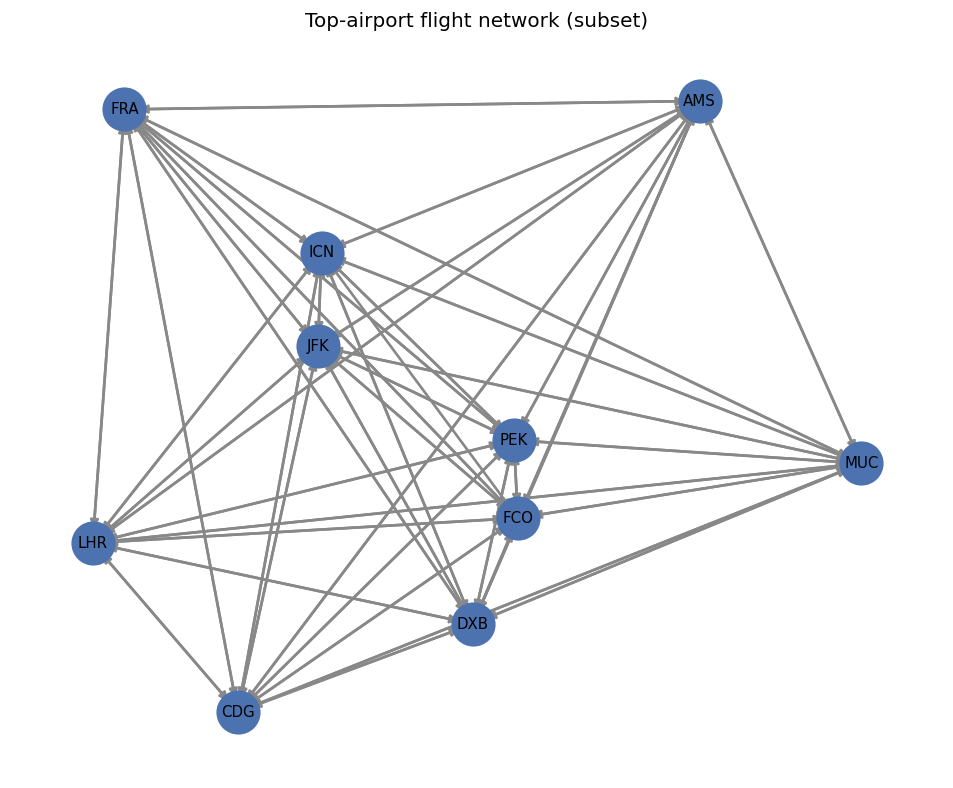

In [ ]:
# Visualize a subgraph using NetworkX for layout and Matplotlib for drawing
def visualize_subgraph(graph, nodes_subset, title):
    nx_graph = nx.DiGraph() if graph.directed else nx.Graph()   # choose graph type
    for node in nodes_subset:
        nx_graph.add_node(node)                                  # add nodes
    for src in nodes_subset:
        for dst, weight in graph.adj.get(src, {}).items():
            if dst in nodes_subset:
                nx_graph.add_edge(src, dst, weight=weight)      # add edges within subset
    pos = nx.spring_layout(nx_graph, seed=42, k=0.4)             # layout positions
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(nx_graph, pos, node_color="#4C72B0", node_size=650)
    nx.draw_networkx_labels(nx_graph, pos, font_size=9)
    nx.draw_networkx_edges(nx_graph, pos, edge_color="#888", width=1.6, arrows=True)
    plt.title(title)
    plt.axis("off")
    plt.show()

focus_nodes = [code for code, _ in leaders[:12]]              # take top 12 airports
visualize_subgraph(routes_graph, focus_nodes, "Top-airport flight network (subset)")

## Practice Exercises: BFS Applications

BFS is perfect for problems where you need the shortest path, closest neighbors, or layer-by-layer exploration. Here are practical exercises to apply BFS to the flight network.


## Practice Exercises: DFS Applications

Now let's explore DFS, which is better for exhaustive exploration, cycle detection, and backtracking problems.


In [ ]:
def compute_network_diameter(graph):
    """Find the maximum shortest path distance in the network"""
    max_distance = 0
    furthest_pair = (None, None)

    def bfs_distances(start):
        """BFS to compute all distances from start"""
        queue = deque([(start, 0)])
        distances = {start: 0}
        max_dist = 0
        farthest = start

        while queue:
            # TODO: BFS to find all reachable nodes and their distances
            # TODO: Track the maximum distance and farthest node
            pass

        return max_dist, farthest

    # TODO: Run BFS from each airport
    # TODO: Track global maximum distance and the pair that achieves it

    return max_distance, furthest_pair


### Exercise 4: Compute Network Diameter

**Goal**: Find the maximum shortest path distance between any two airports (the graph's diameter).

**Why BFS?** Run BFS from every airport and track the maximum distance found.

**Implementation Hints**:
- For each airport, run BFS to find distances to all reachable airports
- Track the maximum distance found from each source
- The overall maximum is the network diameter
- Also track which airport pair achieves this maximum

**Expected Behavior**:
```python
# diameter, (airport1, airport2) = compute_network_diameter(routes_graph)
# print(f"Network diameter: {diameter} hops")
# print(f"Furthest pair: {airport1} <-> {airport2}")
```


In [ ]:
def find_common_hub(graph, start, goal):
    """Find the best connecting hub between two airports using bidirectional BFS"""
    if start not in graph.adj or goal not in graph.adj:
        return None, float('inf')

    # Initialize BFS from both ends
    queue_start = deque([(start, 0)])
    queue_goal = deque([(goal, 0)])
    dist_start = {start: 0}
    dist_goal = {goal: 0}

    best_hub = None
    best_distance = float('inf')

    while queue_start or queue_goal:
        # TODO: Alternate between expanding from start and goal
        # TODO: When expanding from start, check if node is in dist_goal
        # TODO: When expanding from goal, check if node is in dist_start
        # TODO: Update best_hub if total distance is better
        # TODO: Stop when both queues are empty or you've found optimal hub
        pass

    return best_hub, best_distance


### Exercise 3: Find Common Hub Between Two Airports

**Goal**: Find the "closest" common airport that connects two distant airports with minimal total hops.

**Why BFS?** Run BFS from both airports simultaneously (bidirectional BFS) and find where they meet.

**Implementation Hints**:
- Run BFS from both start and goal simultaneously
- Track visited sets for both searches with distances
- When a node is visited by both searches, you've found a meeting point
- Calculate total distance as `dist_from_start + dist_from_goal`
- Return the hub with minimum total distance

**Expected Behavior**:
```python
# hub, total_hops = find_common_hub(routes_graph, "SEA", "MIA")
# print(f"Best connecting hub: {hub} (total: {total_hops} hops)")
```


In [ ]:
def find_destinations_within_hops(graph, start, max_layovers):
    """Find all airports reachable within max_layovers hops"""
    if start not in graph.adj:
        return {}

    queue = deque()
    queue.append((start, 0))           # (airport, distance)
    distances = {start: 0}

    while queue:
        # TODO: Dequeue airport and its distance
        # TODO: If distance >= max_layovers, skip exploring its neighbors
        # TODO: For each unvisited neighbor, record distance and enqueue
        pass

    return distances


### Exercise 2: Find All Destinations Within N Layovers

**Goal**: Find all airports reachable within a specific number of layovers (BFS level constraint).

**Why BFS?** BFS naturally tracks distance/level from the source, making it perfect for "within N hops" queries.

**Implementation Hints**:
- Track the current level/distance as you explore
- Use a tuple `(airport, distance)` in the queue, or track levels separately
- Only add airports to results if distance <= max_layovers
- Return a dictionary mapping each airport to its minimum distance

**Expected Behavior**:
```python
# reachable = find_destinations_within_hops(routes_graph, "JFK", max_layovers=2)
# print(f"Within 2 layovers from JFK: {len(reachable)} airports")
# for airport, hops in sorted(reachable.items(), key=lambda x: x[1])[:5]:
#     print(f"  {airport}: {hops} layovers")
```


In [ ]:
def find_shortest_connection(graph, start, goal):
    """Find the path with fewest hops between two airports"""
    if start not in graph.adj or goal not in graph.adj:
        return [], 0

    queue = deque()
    queue.append(start)
    predecessors = {start: None}

    while queue:
        # TODO: Dequeue the next airport
        # TODO: Check if we've reached the goal
        # TODO: Explore unvisited neighbors and track predecessors
        pass

    # TODO: Reconstruct path from predecessors
    # TODO: Return path and hop count (len(path) - 1)
    return [], 0


### Exercise 1: Find Shortest Connection Path

**Goal**: Find the path with the fewest layovers (hops) between two airports.

**Why BFS?** BFS explores nodes layer by layer, guaranteeing the first path found is the shortest in terms of edges.

**Implementation Hints**:
- Use a queue (deque) for BFS frontier
- Track predecessors to reconstruct the path
- Stop as soon as you reach the destination
- Return both the path and the number of hops

**Expected Behavior**:
```python
# path, hops = find_shortest_connection(routes_graph, "ATL", "SYD")
# print(f"Shortest route: {' -> '.join(path)} ({hops} layovers)")
```


### Exercise 1: Find All Reachable Destinations

**Goal**: Starting from a given airport, find every destination you can reach (directly or through connections).

**Why DFS?** DFS naturally explores the entire connected component without caring about path length.

**Implementation Hints**:
- Start with an empty `visited` set to track airports you've already explored
- Use a recursive approach or a stack (like the DFS function above)
- Keep exploring neighbors until you can't find any unvisited airports
- Return the set of all visited airports

**Expected Behavior**:
```python
# reachable = find_reachable_destinations(routes_graph, "JFK")
# print(f"From JFK you can reach {len(reachable)} airports")
# print(f"Sample destinations: {list(reachable)[:10]}")
```


In [ ]:
def find_reachable_destinations(graph, start):
    """Find all airports reachable from start using DFS"""
    visited = set()                        # track explored airports
    stack = [start]                        # initialize with start airport

    while stack:
        # TODO: Pop an airport from the stack
        # TODO: If already visited, skip it
        # TODO: Mark it as visited
        # TODO: Add all unvisited neighbors to the stack
        pass

    return visited


### Exercise 2: Detect Circular Routes (Round Trips)

**Goal**: Find a round-trip path from an airport back to itself within a maximum number of hops.

**Why DFS?** DFS with backtracking can explore different path combinations and detect when you return to the origin.

**Implementation Hints**:
- Use a recursive DFS that tracks the current path
- Add a `depth` parameter to limit how many stops to explore (prevent infinite loops)
- When you visit a neighbor, check if it's the starting airport AND you've traveled at least 2 hops
- If you find the start again, that's a circular route!
- Use backtracking: after exploring a path, remove the node before trying another

**Expected Behavior**:
```python
# circular = find_circular_route(routes_graph, "JFK", max_depth=4)
# if circular:
#     print(f"Round trip found: {' -> '.join(circular)}")
# else:
#     print("No circular route found within depth limit")
```


In [ ]:
def find_circular_route(graph, start, max_depth=5):
    """Find a circular route starting and ending at start"""

    def dfs_circular(current, path, depth):
        # Base case: reached max depth
        if depth > max_depth:
            return None

        # Explore each neighbor
        for neighbor in graph.neighbors(current):
            # TODO: Check if neighbor is start AND path length >= 2 (found cycle!)
            # TODO: If neighbor not in path, recursively explore it
            # TODO: Add neighbor to path, recurse, then remove (backtrack)
            pass

        return None  # no circular route found

    result = dfs_circular(start, [start], 1)
    return result


### Exercise 3: Find All Paths Between Two Airports

**Goal**: Enumerate all possible flight paths between two airports (with a depth limit to avoid infinite loops).

**Why DFS?** DFS with backtracking explores all possible paths, unlike BFS which only finds the shortest.

**Implementation Hints**:
- Use recursive DFS with a current path list
- When you reach the goal, save a copy of the current path
- Explore each unvisited neighbor recursively
- After exploring, backtrack by removing the neighbor from the path
- Use a depth limit to prevent exploring paths that are too long
- Return a list of all paths found

**Expected Behavior**:
```python
# all_paths = find_all_paths(routes_graph, "JFK", "LAX", max_depth=3)
# print(f"Found {len(all_paths)} different paths")
# for i, path in enumerate(all_paths[:5], 1):
#     print(f"Path {i}: {' -> '.join(path)}")
```


In [ ]:
def find_all_paths(graph, start, goal, max_depth=4):
    """Find all paths from start to goal using DFS with backtracking"""
    all_paths = []                         # collect all valid paths

    def dfs_all_paths(current, path, depth):
        # Base case: reached max depth
        if depth > max_depth:
            return

        # Goal reached: save this path
        if current == goal:
            all_paths.append(path.copy())  # save a copy of the path
            return

        # Explore neighbors
        for neighbor in graph.neighbors(current):
            # TODO: Skip if neighbor already in path (avoid cycles)
            # TODO: Add neighbor to path
            # TODO: Recursively explore from neighbor
            # TODO: Remove neighbor from path (backtrack)
            pass

    dfs_all_paths(start, [start], 1)
    return all_paths


### Exercise 4: Check Network Connectivity

**Goal**: Determine if the flight network is fully connected, or if there are isolated groups of airports.

**Why DFS?** DFS can explore one connected component completely. If it doesn't visit all nodes, the graph is disconnected.

**Implementation Hints**:
- Run DFS from an arbitrary starting node
- Count how many nodes you visited
- If visited count equals total nodes, the graph is connected
- Otherwise, find unvisited nodes and run DFS again to find separate components
- Repeat until all nodes are assigned to a component

**Expected Behavior**:
```python
# components = find_connected_components(routes_graph)
# print(f"The network has {len(components)} connected component(s)")
# for i, component in enumerate(components, 1):
#     print(f"Component {i}: {len(component)} airports")
```


In [ ]:
def find_connected_components(graph):
    """Find all connected components in the graph"""
    visited = set()                        # track globally visited nodes
    components = []                        # list of components (each is a set)

    def dfs_component(start):
        """DFS to find one complete component"""
        component = set()                  # nodes in this component
        stack = [start]

        while stack:
            # TODO: Pop a node
            # TODO: Skip if already visited globally
            # TODO: Mark as visited and add to component
            # TODO: Add unvisited neighbors to stack
            pass

        return component

    # Find all components
    for node in graph.nodes():
        # TODO: If node not visited, it's in a new component
        # TODO: Run DFS from this node to find the entire component
        # TODO: Add component to list
        pass

    return components


### Exercise 5: Path with Maximum Stops

**Goal**: Find the longest simple path (no repeated airports) between two airports within a depth limit.

**Implementation Hints**:
- Similar to finding all paths, but track the longest one found
- Use DFS with backtracking
- Compare path lengths and keep the maximum
- A "simple path" means no airport appears twice

**Try implementing this yourself using the patterns from exercises 2 and 3!**